In [1]:
import torch.nn as nn
from tqdm import tqdm
import logging
from torch.utils.tensorboard import  SummaryWriter
import torch.nn.functional as F
import numpy as np
import os
import copy
import torch
import torchvision
from PIL import Image
import torch.functional
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import optim
from torchvision.datasets import DatasetFolder, ImageFolder
from imgaug import augmenters as iaa
import imgaug as ia
import PIL

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

train_cond = True
batch_size = 90
n_epochs = 50
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#uso la trasformazione con i valori di media e deviazione standard tipici della normalizzazione per foto rgb usati nella ResNe
transform = transforms.Compose([
    torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
    torchvision.transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomChoice([
    transforms.Lambda(lambda x: torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.01, 0.25))(x) if torch.rand(1) < 0.5 else x),]),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(),
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomApply([
            transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_hue(x, 0.1)),
            transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_saturation(x, 0.1)),
        ], p=0.5),
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

db = "/kaggle/input/dataset-3/db3"


dataset = torchvision.datasets.ImageFolder(db, transform=transform)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [5]:
class Diffusion:
    def __init__(self, noise_steps=500, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

In [8]:
class MyUNetConditioned(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256,num_classes=None, device="cuda"):
        super().__init__()
        self.time_dim = time_dim
        self.device = device

        self.init = DoubleConv(c_in,64)

        self.maxpool_conv1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 64, residual=True),
            DoubleConv(64, 128),
        )
        self.emb_layer1 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim,128),
        )
        self.sa1 = nn.Sequential(
            SelfAttention(128,32)
        )

        self.maxpool_conv2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 128, residual=True),
            DoubleConv(128, 256),
        )
        self.emb_layer2 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim,256),
        )
        self.sa1_1 = nn.Sequential(
            SelfAttention(256,16)
        )

        self.maxpool_conv2_1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 256, residual=True),
            DoubleConv(256, 256),
        )
        self.emb_layer2_1 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim,256),
        )


        #Bottleneck
        self.bottleneck = nn.Sequential(
            DoubleConv(256, 512),
            DoubleConv(512, 512),
            DoubleConv(512, 256),
        )


        self.up3 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up_conv3 = nn.Sequential(
            DoubleConv(512, 512, residual=True),
            DoubleConv(512, 128),
        )
        self.emb_layer3 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim,128),
        )
        self.sa2 = nn.Sequential(
            SelfAttention(128,16)
        )

        self.up3_1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up_conv3_1 = nn.Sequential(
            DoubleConv(256, 256, residual=True),
            DoubleConv(256, 64),
        )
        self.emb_layer3_1 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim,64),
        )
        self.sa1_2 = nn.Sequential(
            SelfAttention(64,32)
        )

        self.up4 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up_conv4 = nn.Sequential(
            DoubleConv(128, 128, residual=True),
            DoubleConv(128, 64),
        )
        self.emb_layer4 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim,64),
        )
        

        self.exit = nn.Conv2d(64,c_out,1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x = self.init(x)


        x1 = self.maxpool_conv1(x)
        emb1 = self.emb_layer1(t)[:, :, None, None].repeat(1, 1, x1.shape[-2], x1.shape[-1])
        x1 = x1 + emb1
        x1 = self.sa1(x1)


        x2 = self.maxpool_conv2(x1)
        emb2 = self.emb_layer2(t)[:, :, None, None].repeat(1, 1, x2.shape[-2], x2.shape[-1])
        x2 = x2 + emb2
        x2 = self.sa1_1(x2)


        x2_1 = self.maxpool_conv2_1(x2)
        emb2_1 = self.emb_layer2_1(t)[:, :, None, None].repeat(1, 1, x2_1.shape[-2], x2_1.shape[-1])
        x2_1 = x2_1 + emb2_1

        #Bottleneck
        bottleneck = self.bottleneck(x2_1)


        x3 = self.up3(bottleneck)
        x3 = torch.cat((x3, x2), dim=1)
        x3 = self.up_conv3(x3)
        emb3 = self.emb_layer3(t)[:, :, None, None].repeat(1, 1, x3.shape[-2], x3.shape[-1])
        x3 = x3 + emb3
        x3 = self.sa2(x3)


        x3_1 = self.up3_1(x3)
        x3_1 = torch.cat((x3_1, x1), dim=1)
        x3_1 = self.up_conv3_1(x3_1)
        emb3_1 = self.emb_layer3_1(t)[:, :, None, None].repeat(1, 1, x3_1.shape[-2], x3_1.shape[-1])
        x3_1 = x3_1 + emb3_1
        x3_1 = self.sa1_2(x3_1)
        

        x4 = self.up3_1(x3_1)
        x4 = torch.cat((x4, x), dim=1)
        x4 = self.up_conv4(x4)
        emb4 = self.emb_layer4(t)[:, :, None, None].repeat(1, 1, x4.shape[-2], x4.shape[-1])
        x4 = x4 + emb4
        

        return self.exit(x4)

In [9]:
def plot_images(images, num_samples):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images[:num_samples].to(device)], dim=-1),], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [10]:
def train(run_name = "DDPM_Uncondtional",epochs = 500,image_size = 64, device = "cuda",lr = 3e-4,num_classes = 22):
    device = device
    dataloader = loader
    model = MyUNetConditioned(num_classes=num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=image_size, device=device)
    #logger = SummaryWriter(os.path.join("runs", run_name))
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    for epoch in range(epochs):
        #logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)
            pbar.set_postfix(MSE=loss.item())
            #logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        if (epoch + 1) % 50 == 0:
            labels = torch.arange(num_classes).long().to(device)
            sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
            ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            print("Epoch number: ", epoch+1)
            plot_images(sampled_images,22)
            plot_images(ema_sampled_images,22)
            #plot_images(ema_sampled_images, 8)
            save_images(sampled_images, os.path.join("results", "/kaggle/working/", f"{epoch}.jpg"))
            save_images(ema_sampled_images, os.path.join("results_ema", "/kaggle/working/", f"{epoch}.jpg"))
            #torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))

Total number of parameters:  21995395


100%|██████████| 112/112 [01:23<00:00,  1.34it/s, MSE=0.019] 
499it [00:50,  9.98it/s]
499it [00:50,  9.98it/s]


Epoch number:  50


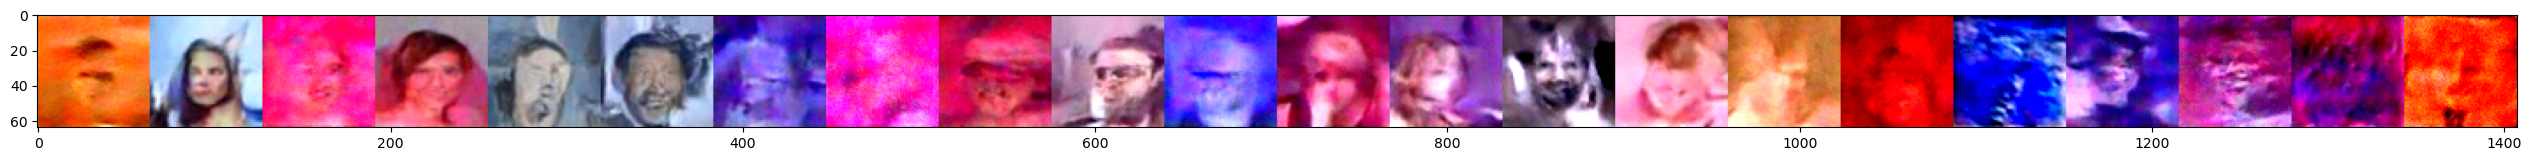

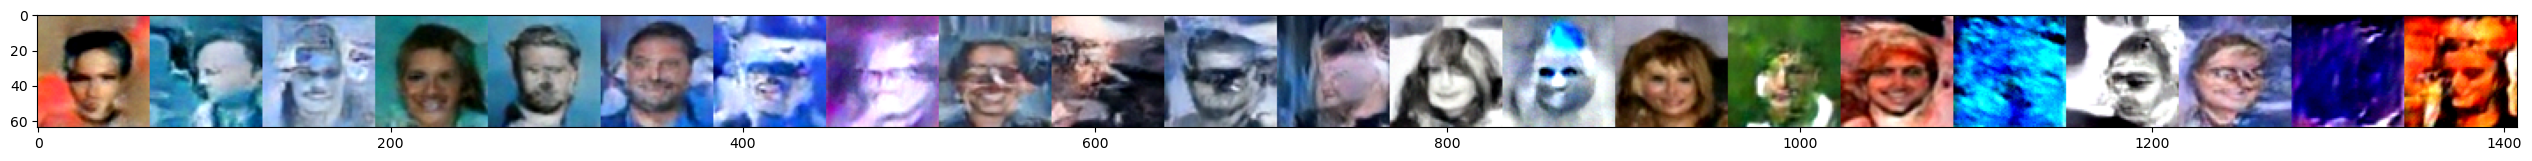

  3%|▎         | 3/112 [00:02<01:20,  1.36it/s, MSE=0.021] 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = MyUNetConditioned(num_classes = 22)

total_params = count_parameters(model)
print("Total number of parameters: ", total_params)

train(run_name = "DDPM_Uncondtional",
    epochs = 500,
    image_size = 64,
    #dataset_path = r"C:\Users\dome\datasets\landscape_img_folder",
    device = "cuda",
    lr = 3e-4)